In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from soilgen_ai.logging_config import setup_logging
import pyarrow.parquet as pq

from pathlib import Path

# Setup logging and seaborn
logger = setup_logging()
sns.set_palette("colorblind")
np.random.seed(42)

In [3]:
# Load the data
project_root = Path.cwd().parent.parent
file_path = project_root / "data" / "vspdb_vs_profiles.parquet"
table = pq.read_table(file_path)
df = table.to_pandas()
logger.info(f"Data loaded with shape: {df.shape}")

2025-09-10 11:30:37,695 - soilgen_ai.logging_config - INFO - Data loaded with shape: (354220, 3)


In [4]:
# Convert data
profiles_dict = {
    metadata_id: group.sort_values("depth")
    .drop(columns=["velocity_metadata_id"])
    .reset_index(drop=True)
    for metadata_id, group in df.groupby("velocity_metadata_id")
}

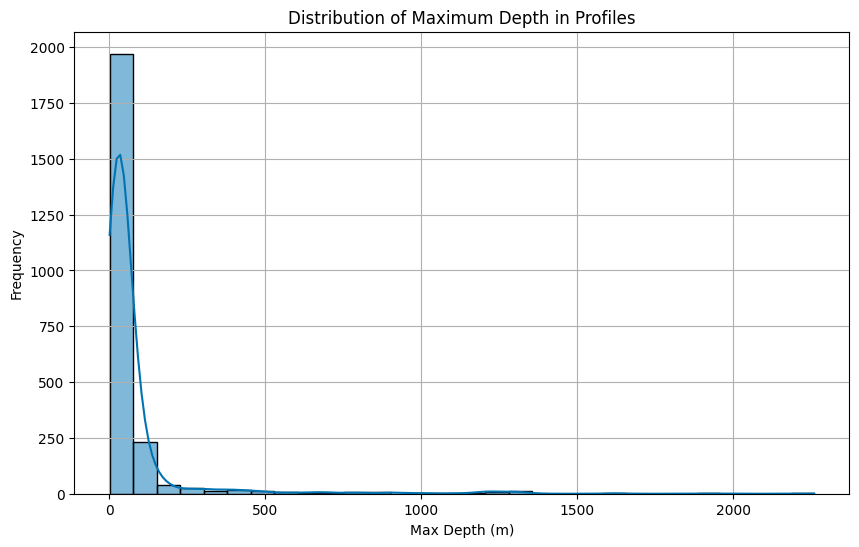

In [5]:
## Distribution of max depth in each profile
max_depths = [profile["depth"].max() for profile in profiles_dict.values()]
plt.figure(figsize=(10, 6))
sns.histplot(max_depths, bins=30, kde=True)
plt.title("Distribution of Maximum Depth in Profiles")
plt.xlabel("Max Depth (m)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [6]:
# Compute Vs30 for each profile
def compute_vs30(profile):
    # Ensure the profile is sorted by depth
    profile = profile.sort_values("depth").reset_index(drop=True)

    # Initialize variables
    total_depth = 0
    weighted_velocity_sum = 0

    # Iterate through the layers to compute Vs30
    for i in range(len(profile) - 1):
        layer_top = profile.loc[i, "depth"]
        layer_bottom = profile.loc[i + 1, "depth"]
        layer_velocity = profile.loc[i, "vs_value"]

        layer_thickness = layer_bottom - layer_top

        if total_depth + layer_thickness >= 30:
            # Only take the portion of the layer that contributes to the first 30m
            remaining_depth = 30 - total_depth
            weighted_velocity_sum += layer_velocity * remaining_depth
            total_depth += remaining_depth
            break
        else:
            weighted_velocity_sum += layer_velocity * layer_thickness
            total_depth += layer_thickness

    # If the profile is shallower than 30m, use the average velocity of the available depth
    if total_depth < 30:
        return weighted_velocity_sum / total_depth if total_depth > 0 else None

    return weighted_velocity_sum / 30

In [7]:
vs30 = [compute_vs30(profile) for profile in profiles_dict.values()]

2025-09-10 11:30:43,989 - soilgen_ai.logging_config - INFO - Vs30 Statistics: Mean=472.17, Median=352.23, Std=342.64
2025-09-10 11:30:43,991 - soilgen_ai.logging_config - INFO - Vs30 Min=30.48, Max=2830.07


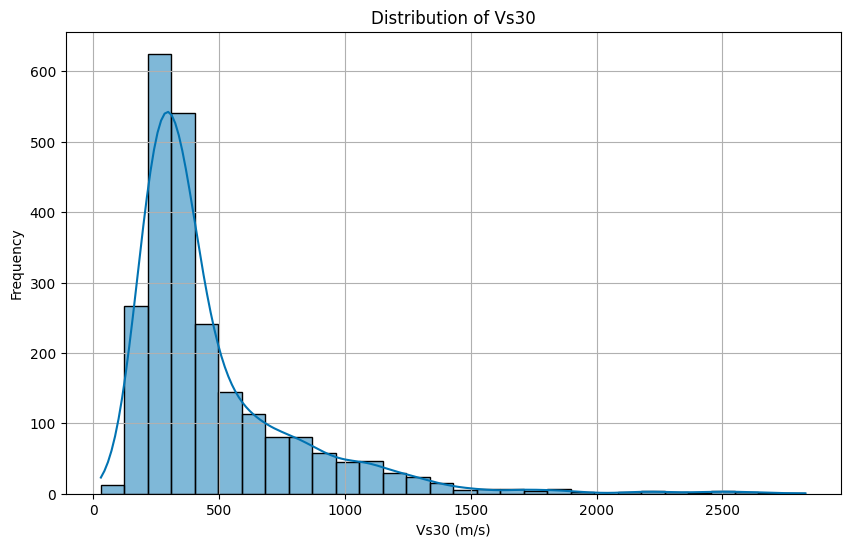

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(vs30, bins=30, kde=True)
plt.title("Distribution of Vs30")
plt.xlabel("Vs30 (m/s)")
plt.ylabel("Frequency")
plt.grid()

# Print statistics of Vs30
vs30_array = np.array(vs30)
logger.info(
    f"Vs30 Statistics: Mean={np.nanmean(vs30_array):.2f}, Median={np.nanmedian(vs30_array):.2f}, Std={np.nanstd(vs30_array):.2f}"
)
logger.info(f"Vs30 Min={np.nanmin(vs30_array):.2f}, Max={np.nanmax(vs30_array):.2f}")

In [9]:
# Compute Vs at any depth Z
def compute_vs_at_depth(profile, depth):
    # Ensure the profile is sorted by depth
    profile = profile.sort_values("depth").reset_index(drop=True)

    # Initialize variables
    total_depth = 0
    weighted_velocity_sum = 0

    # Iterate through the layers to compute Vs at depth Z
    for i in range(len(profile) - 1):
        layer_top = profile.loc[i, "depth"]
        layer_bottom = profile.loc[i + 1, "depth"]
        layer_velocity = profile.loc[i, "vs_value"]

        layer_thickness = layer_bottom - layer_top

        if total_depth + layer_thickness >= depth:
            # Only take the portion of the layer that contributes to the first Z meters
            remaining_depth = depth - total_depth
            weighted_velocity_sum += layer_velocity * remaining_depth
            total_depth += remaining_depth
            break
        else:
            weighted_velocity_sum += layer_velocity * layer_thickness
            total_depth += layer_thickness

    # If the profile is shallower than Z meters, use the average velocity of the available depth
    if total_depth < depth:
        return weighted_velocity_sum / total_depth if total_depth > 0 else None

    return weighted_velocity_sum / depth

In [10]:
vs_1km = [compute_vs_at_depth(profile, 1000) for profile in profiles_dict.values()]
vs_2km = [compute_vs_at_depth(profile, 2000) for profile in profiles_dict.values()]

In [11]:
len(vs_1km), len(vs_2km), len(vs30), len(profiles_dict)

(2369, 2369, 2369, 2369)

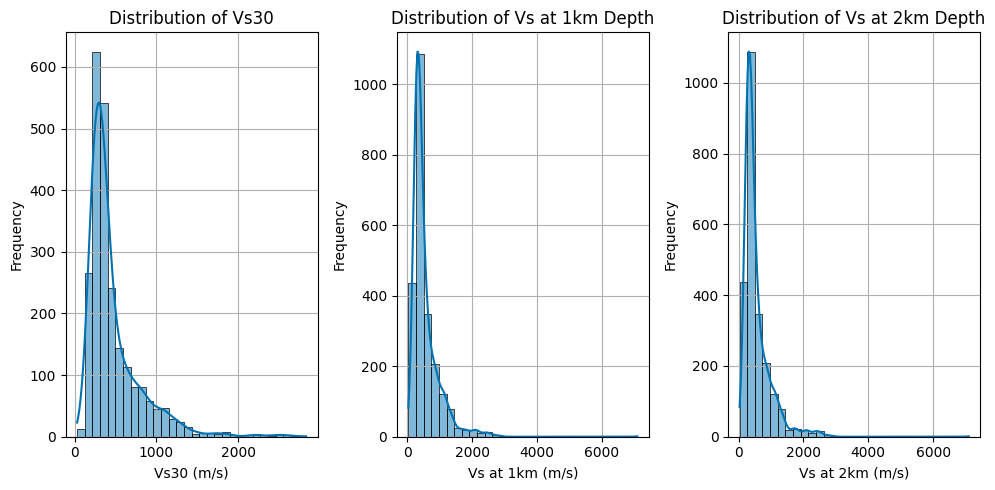

In [12]:
# Do three subfigures for each vs_depth we computed
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.histplot(vs30, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Vs30")
axes[0].set_xlabel("Vs30 (m/s)")
axes[0].set_ylabel("Frequency")
axes[0].grid()
sns.histplot(vs_1km, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Vs at 1km Depth")
axes[1].set_xlabel("Vs at 1km (m/s)")
axes[1].set_ylabel("Frequency")
axes[1].grid()
sns.histplot(vs_2km, bins=30, kde=True, ax=axes[2])
axes[2].set_title("Distribution of Vs at 2km Depth")
axes[2].set_xlabel("Vs at 2km (m/s)")
axes[2].set_ylabel("Frequency")
axes[2].grid()
plt.tight_layout()
plt.show()

In [13]:
# Calculate the two-way travel time profiles
def Vs_to_tts(profile):
    profile = profile.sort_values("depth").reset_index(drop=True)
    profile["tts"] = 2 * (
        profile["depth"].diff().fillna(profile["depth"]) / profile["vs_value"]
    )
    profile["tts"] = profile["tts"].cumsum()
    return profile


# Try
tts_profiles = {
    metadata_id: Vs_to_tts(profile) for metadata_id, profile in profiles_dict.items()
}


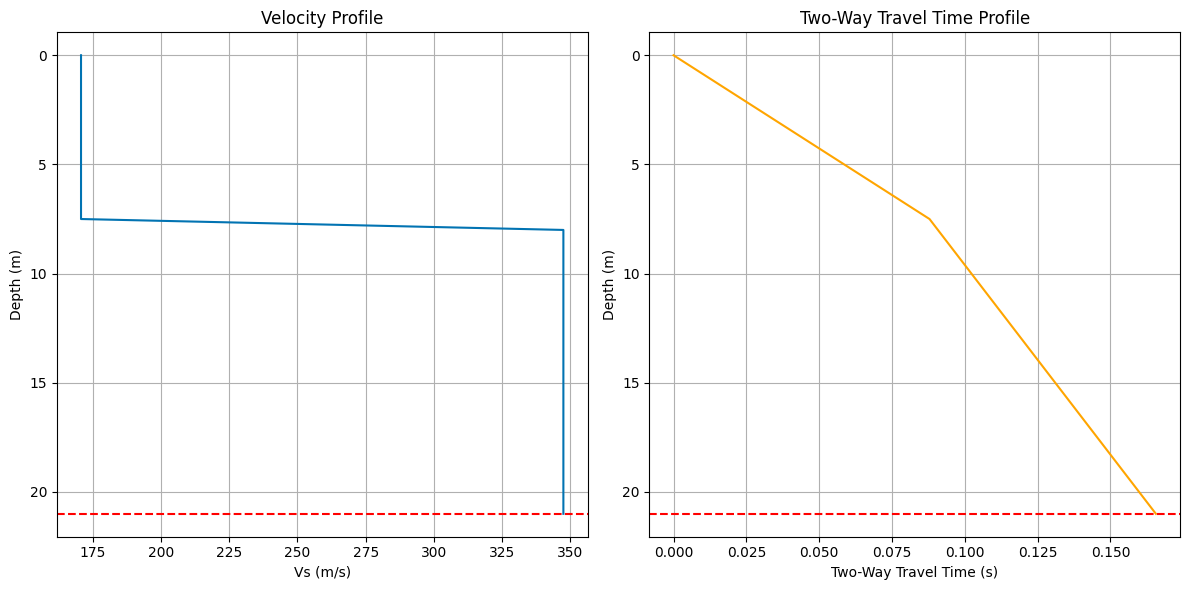

In [14]:
idx = np.random.choice(list(profiles_dict.keys()), size=1, replace=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(profiles_dict[idx[0]]["vs_value"], profiles_dict[idx[0]]["depth"])
ax[0].axhline(
    profiles_dict[idx[0]]["depth"].max(), color="red", linestyle="--", label="Max Depth"
)
ax[0].set_title("Velocity Profile")
ax[0].set_xlabel("Vs (m/s)")
ax[0].set_ylabel("Depth (m)")
ax[0].invert_yaxis()
ax[0].grid()

ax[1].plot(tts_profiles[idx[0]]["tts"], tts_profiles[idx[0]]["depth"], color="orange")
ax[1].axhline(
    tts_profiles[idx[0]]["depth"].max(), color="red", linestyle="--", label="Max Depth"
)
ax[1].set_title("Two-Way Travel Time Profile")
ax[1].set_xlabel("Two-Way Travel Time (s)")
ax[1].set_ylabel("Depth (m)")
ax[1].invert_yaxis()
ax[1].grid()
plt.tight_layout()
plt.show()


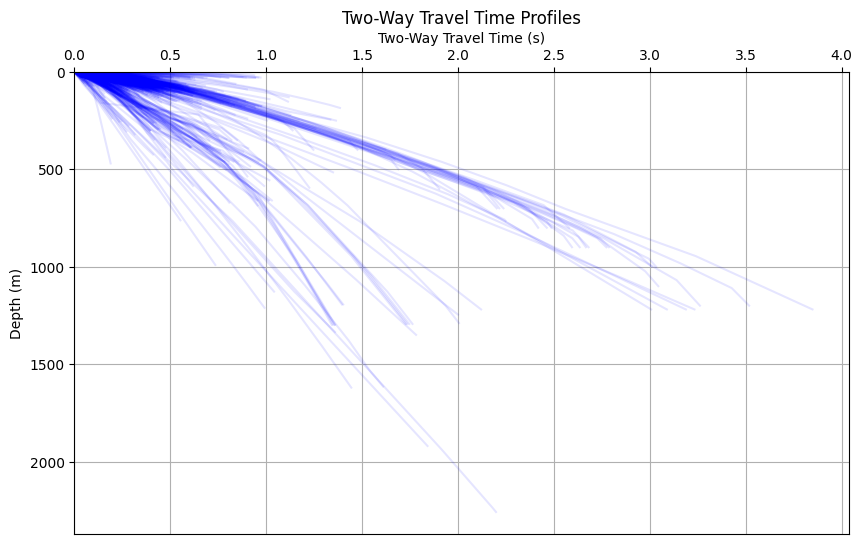

In [15]:
# Plot all the tts profiles in three subplots, one with normal units, then yscale log, then xscale log, and both log
plt.figure(figsize=(10, 6))
for profile in tts_profiles.values():
    plt.plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")

plt.title("Two-Way Travel Time Profiles")
plt.xlabel("Two-Way Travel Time (s)")
plt.ylabel("Depth (m)")
# Xlabel and ticks on top
plt.gca().xaxis.set_label_position("top")
plt.gca().xaxis.tick_top()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.gca().invert_yaxis()
plt.grid()
plt.show()

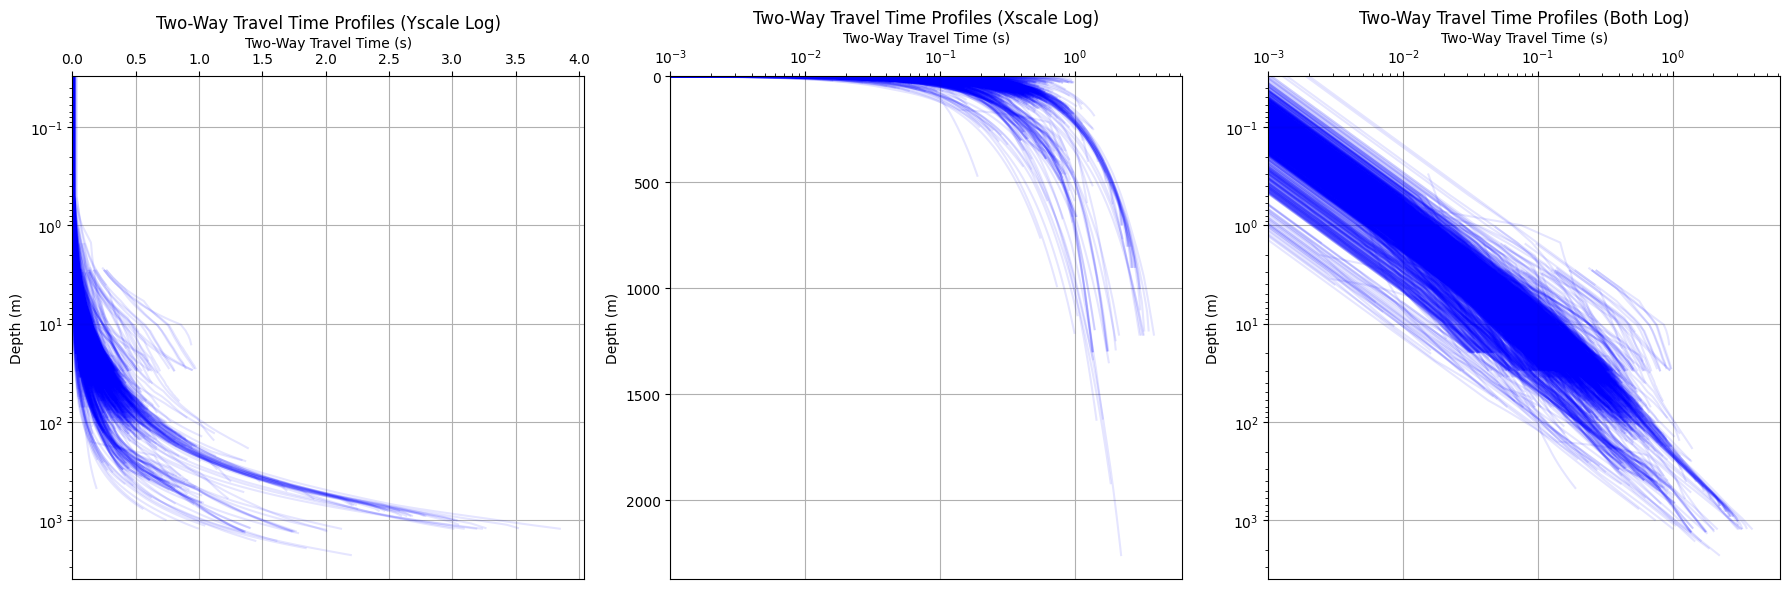

In [16]:
# Plot all the tts profiles in three subplots, one with yscale log, then xscale log, and both log
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for profile in tts_profiles.values():
    ax[0].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[1].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[2].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")

ax[0].set_title("Two-Way Travel Time Profiles (Yscale Log)")
ax[0].set_yscale("log")
ax[1].set_title("Two-Way Travel Time Profiles (Xscale Log)")
ax[1].set_xscale("log")
ax[2].set_title("Two-Way Travel Time Profiles (Both Log)")
ax[2].set_xscale("log")
ax[2].set_yscale("log")

# Use a small positive value for log scales
min_tts = min(
    [profile["tts"][profile["tts"] > 0].min() for profile in tts_profiles.values()]
)
min_depth = min(
    [profile["depth"][profile["depth"] > 0].min() for profile in tts_profiles.values()]
)
eps = 1e-3
x_min = max(min_tts, eps)
y_min = max(min_depth, eps)


ax[0].set_xlim(left=0)
ax[0].set_ylim(bottom=y_min)
ax[1].set_xlim(left=x_min)
ax[1].set_ylim(bottom=0)
ax[2].set_xlim(left=x_min)
ax[2].set_ylim(bottom=y_min)
# Xlabel and ticks on top
for a in ax:
    a.set_xlabel("Two-Way Travel Time (s)")
    a.set_ylabel("Depth (m)")
    a.xaxis.set_label_position("top")
    a.xaxis.tick_top()
    a.grid()
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()


plt.tight_layout()
plt.show()

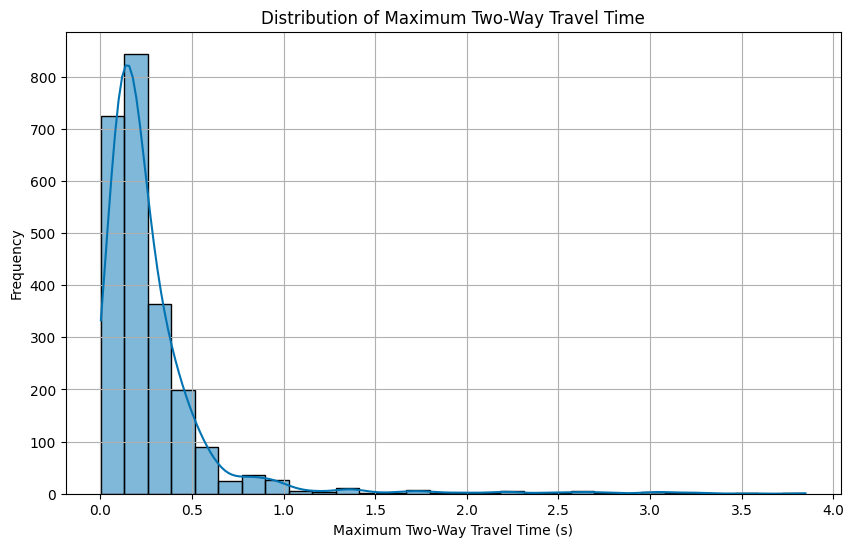

In [17]:
# Statistics on tts

## Distribution of max tts in each profile
max_tts = [profile["tts"].max() for profile in tts_profiles.values()]
plt.figure(figsize=(10, 6))
sns.histplot(max_tts, bins=30, kde=True)
plt.title("Distribution of Maximum Two-Way Travel Time")
plt.xlabel("Maximum Two-Way Travel Time (s)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

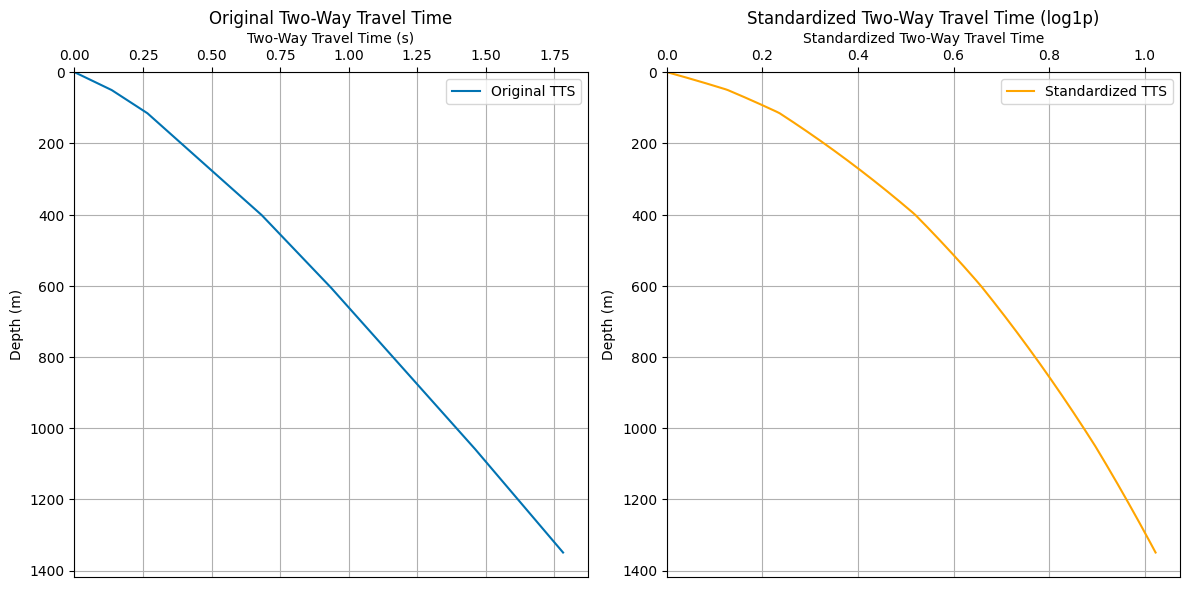

In [18]:
# Understanding the standarization we are doing with log1p

standardized_tts = {
    metadata_id: pd.DataFrame(
        {
            "depth": profile["depth"],
            "vs_value": profile["vs_value"],
            "tts": np.log1p(profile["tts"]),
        }
    )
    for metadata_id, profile in tts_profiles.items()
}


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(
    x=tts_profiles[1]["tts"], y=tts_profiles[1]["depth"], label="Original TTS", ax=ax[0]
)
sns.lineplot(
    x=standardized_tts[1]["tts"],
    y=standardized_tts[1]["depth"],
    label="Standardized TTS",
    color="orange",
    ax=ax[1],
)

# Set titles and labels
ax[0].set_title("Original Two-Way Travel Time")
ax[0].set_xlabel("Two-Way Travel Time (s)")
ax[0].set_ylabel("Depth (m)")
ax[1].set_title("Standardized Two-Way Travel Time (log1p)")
ax[1].set_xlabel("Standardized Two-Way Travel Time")
ax[1].set_ylabel("Depth (m)")

# Consistent axis formatting and grid
for a in ax:
    a.set_xlim(left=0)
    a.set_ylim(bottom=0)
    a.xaxis.set_label_position("top")
    a.xaxis.tick_top()
    a.grid(True)
    a.invert_yaxis()

plt.tight_layout()
plt.show()


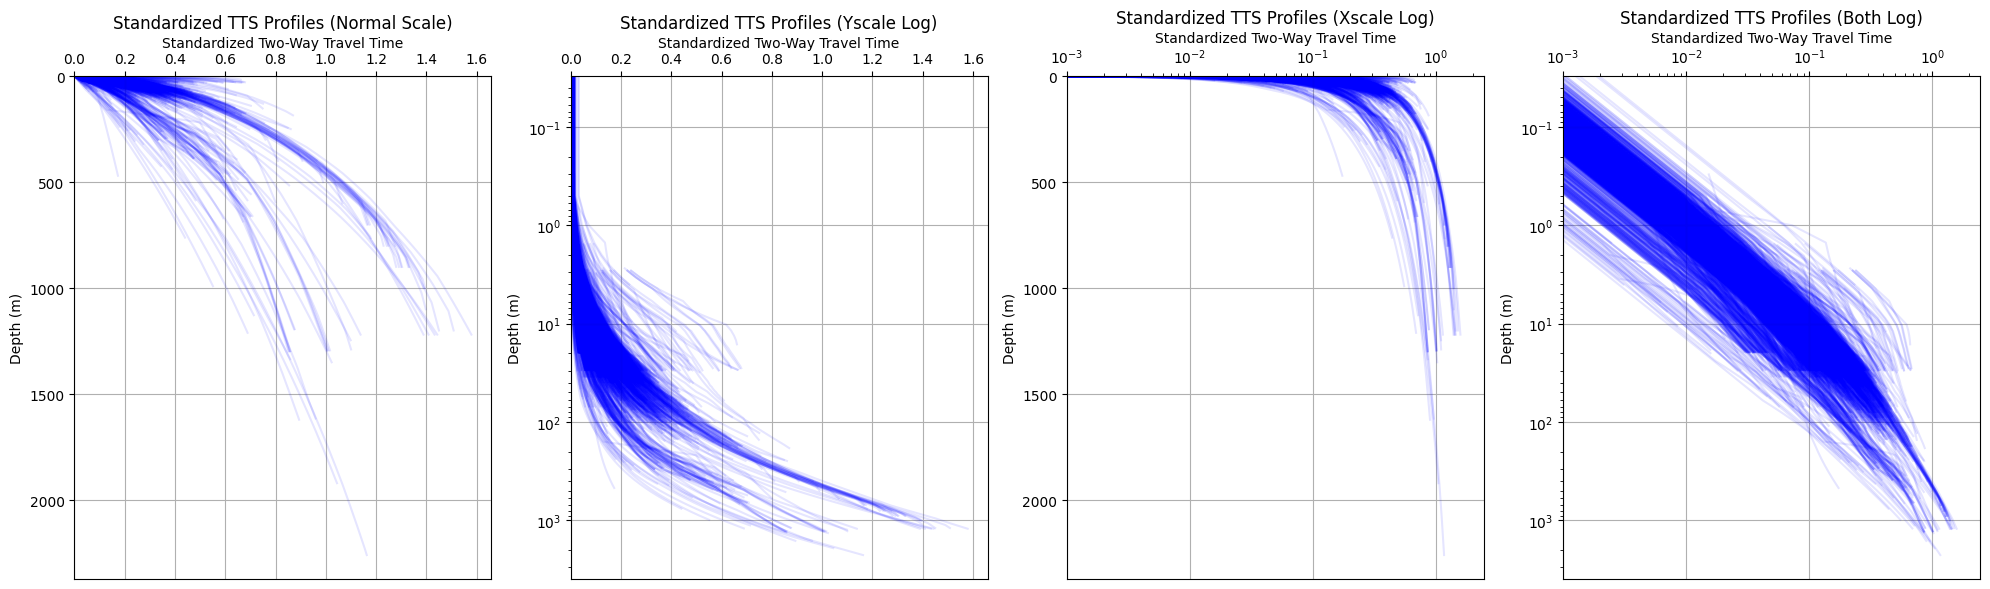

In [19]:
# Plot all the standardized tts profiles in four subplots, one with normal units, then yscale log, then xscale log, and both log
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for profile in standardized_tts.values():
    ax[0].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[1].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[2].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")
    ax[3].plot(profile["tts"], profile["depth"], alpha=0.1, color="blue")

ax[0].set_title("Standardized TTS Profiles (Normal Scale)")
ax[1].set_title("Standardized TTS Profiles (Yscale Log)")
ax[1].set_yscale("log")
ax[2].set_title("Standardized TTS Profiles (Xscale Log)")
ax[2].set_xscale("log")
ax[3].set_title("Standardized TTS Profiles (Both Log)")
ax[3].set_xscale("log")
ax[3].set_yscale("log")
# Use a small positive value for log scales
min_tts = min(
    [profile["tts"][profile["tts"] > 0].min() for profile in standardized_tts.values()]
)
min_depth = min(
    [
        profile["depth"][profile["depth"] > 0].min()
        for profile in standardized_tts.values()
    ]
)
eps = 1e-3
x_min = max(min_tts, eps)
y_min = max(min_depth, eps)

ax[0].set_xlim(left=0)
ax[0].set_ylim(bottom=0)
ax[1].set_xlim(left=0)
ax[1].set_ylim(bottom=y_min)
ax[2].set_xlim(left=x_min)
ax[2].set_ylim(bottom=0)
ax[3].set_xlim(left=x_min)
ax[3].set_ylim(bottom=y_min)
# Xlabel and ticks on top
for a in ax:
    a.set_xlabel("Standardized Two-Way Travel Time")
    a.set_ylabel("Depth (m)")
    a.xaxis.set_label_position("top")
    a.xaxis.tick_top()
    a.grid()
    a.invert_yaxis()

plt.tight_layout()
plt.show()

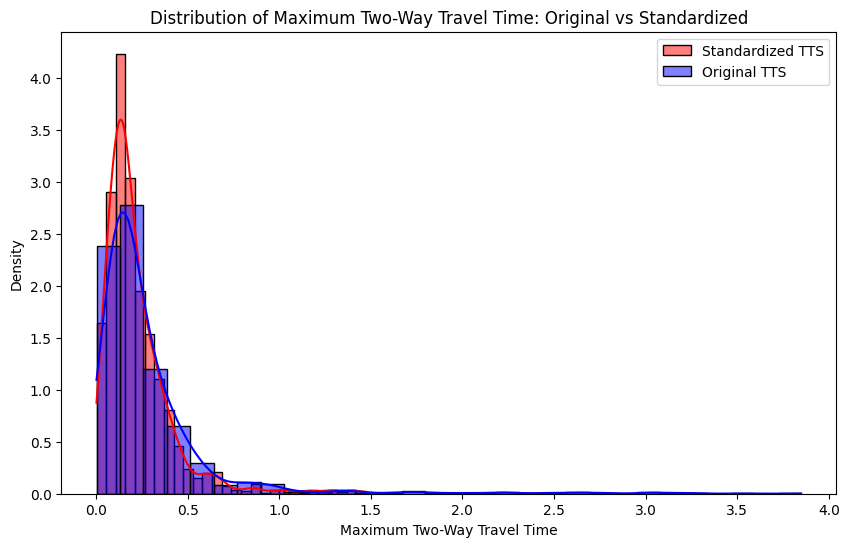

In [20]:
## Distribution of max standardized tts in each profile compared with max original tts
max_standardized_tts = [df["tts"].max() for df in standardized_tts.values()]
max_standardized_tts = [df["tts"].max() for df in standardized_tts.values()]
max_original_tts = [profile["tts"].max() for profile in tts_profiles.values()]

plt.figure(figsize=(10, 6))
sns.histplot(
    max_standardized_tts,
    bins=30,
    kde=True,
    color="red",
    label="Standardized TTS",
    stat="density",
)
sns.histplot(
    max_original_tts,
    bins=30,
    kde=True,
    color="blue",
    label="Original TTS",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Maximum Two-Way Travel Time: Original vs Standardized")
plt.xlabel("Maximum Two-Way Travel Time")
plt.ylabel("Density")
plt.legend()
plt.show()

In [21]:
from soilgen_ai.tts_profiles.check import TTSProfileProcessor

good_data = {
    "depth": [0.0, 0.5, 1.0, 1.5, 2.0],
    "vs_value": [738, 738, 738, 800, 800],
    "tts": [0.00000, 0.00136, 0.00271, 0.00400, 0.00525],
}
bad_data = {
    "depth": [0.0, 0.5, 1.0, 1.5, 2.0],
    "vs_value": [205, 205, 950, 950, 950],
    "tts": [0.00000, 0.00488, 0.00593, 0.00550, 0.00655],  # Decrease at index 3
}

tts_profiles_database = {
    1: pd.DataFrame(good_data),
    2: pd.DataFrame(bad_data),
}

# 2. Instantiate and run the processor
processor = TTSProfileProcessor(tts_profiles_database)
processor.process_profiles()

# 3. Generate the final report
processor.generate_report()

2025-09-10 11:31:35,626 - soilgen_ai.logging_config - INFO - --- Starting Enhanced TTS Profile Processing ---
2025-09-10 11:31:35,633 - soilgen_ai.logging_config - INFO - Processing complete.
2025-09-10 11:31:35,636 - soilgen_ai.logging_config - INFO - 
--- TTS Profile Validation Report ---
2025-09-10 11:31:35,638 - soilgen_ai.logging_config - INFO - Total Profiles Processed: 2
2025-09-10 11:31:35,640 - soilgen_ai.logging_config - INFO - ✅ Valid Profiles: 1
2025-09-10 11:31:35,644 - soilgen_ai.logging_config - WARNING - ❌ Invalid Profiles: 1
2025-09-10 11:31:35,646 - soilgen_ai.logging_config - WARNING - 
--- Diagnostics for Invalid Profiles ---
2025-09-10 11:31:35,647 - soilgen_ai.logging_config - WARNING -   - Profile ID: 2, Reason: Non-monotonic TTS
2025-09-10 11:31:35,648 - soilgen_ai.logging_config - WARNING -     -> Violation at index 3: 'tts' decreases from 0.00593 to 0.00550
2025-09-10 11:31:35,649 - soilgen_ai.logging_config - INFO - 
--- Analysis of Valid Profiles ---
2025-09

   depth  vs_value       tts  calculated_vs_mps  vs_diff_percent
0    0.0       738  0.00e+00             735.29        -3.67e-01
1    0.5       738  1.36e-03             740.74         3.71e-01
2    1.0       738  2.71e-03             775.19         5.04e+00
3    1.5       800  4.00e-03             800.00        -1.42e-14
4    2.0       800  5.25e-03                NaN              NaN


In [22]:
processor = TTSProfileProcessor(tts_profiles)
processor.process_profiles()
processor.generate_report()

2025-09-10 11:31:35,677 - soilgen_ai.logging_config - INFO - --- Starting Enhanced TTS Profile Processing ---
2025-09-10 11:31:41,250 - soilgen_ai.logging_config - INFO - Processing complete.
2025-09-10 11:31:41,251 - soilgen_ai.logging_config - INFO - 
--- TTS Profile Validation Report ---
2025-09-10 11:31:41,252 - soilgen_ai.logging_config - INFO - Total Profiles Processed: 2369
2025-09-10 11:31:41,253 - soilgen_ai.logging_config - INFO - ✅ Valid Profiles: 2369
2025-09-10 11:31:41,254 - soilgen_ai.logging_config - WARNING - ❌ Invalid Profiles: 0
2025-09-10 11:31:41,254 - soilgen_ai.logging_config - INFO - 
--- Analysis of Valid Profiles ---
2025-09-10 11:31:41,255 - soilgen_ai.logging_config - INFO - Showing example from Profile ID: 1
2025-09-10 11:31:41,395 - soilgen_ai.logging_config - INFO - 
--- Sanity Check Summary (Calculated Vs vs. Original Vs) ---
2025-09-10 11:31:41,399 - soilgen_ai.logging_config - INFO - Mean Difference: 1.22%
2025-09-10 11:31:41,407 - soilgen_ai.logging_c

       depth  vs_value       tts  calculated_vs_mps  vs_diff_percent
0        0.0     738.0  0.00e+00              738.0         0.00e+00
1        0.5     738.0  1.36e-03              738.0         0.00e+00
2        1.0     738.0  2.71e-03              738.0         3.08e-14
...      ...       ...       ...                ...              ...
2697  1348.5    1812.0  1.78e+00             1812.0        -1.06e-11
2698  1349.0    1812.0  1.78e+00             1812.0        -1.06e-11
2699  1349.5    1812.0  1.78e+00                NaN              NaN

[2700 rows x 5 columns]


In [23]:
processor = TTSProfileProcessor(standardized_tts)
processor.process_profiles()
processor.generate_report()

2025-09-10 11:31:41,460 - soilgen_ai.logging_config - INFO - --- Starting Enhanced TTS Profile Processing ---
2025-09-10 11:31:46,182 - soilgen_ai.logging_config - INFO - Processing complete.
2025-09-10 11:31:46,183 - soilgen_ai.logging_config - INFO - 
--- TTS Profile Validation Report ---
2025-09-10 11:31:46,184 - soilgen_ai.logging_config - INFO - Total Profiles Processed: 2369
2025-09-10 11:31:46,185 - soilgen_ai.logging_config - INFO - ✅ Valid Profiles: 2369
2025-09-10 11:31:46,186 - soilgen_ai.logging_config - WARNING - ❌ Invalid Profiles: 0
2025-09-10 11:31:46,187 - soilgen_ai.logging_config - INFO - 
--- Analysis of Valid Profiles ---
2025-09-10 11:31:46,188 - soilgen_ai.logging_config - INFO - Showing example from Profile ID: 1


       depth  vs_value       tts  calculated_vs_mps  vs_diff_percent
0        0.0     738.0  0.00e+00             738.50             0.07
1        0.5     738.0  1.35e-03             739.50             0.20
2        1.0     738.0  2.71e-03             740.50             0.34
...      ...       ...       ...                ...              ...
2697  1348.5    1812.0  1.02e+00            5038.46           178.06
2698  1349.0    1812.0  1.02e+00            5039.46           178.12
2699  1349.5    1812.0  1.02e+00                NaN              NaN

[2700 rows x 5 columns]


2025-09-10 11:31:46,821 - soilgen_ai.logging_config - INFO - 
--- Sanity Check Summary (Calculated Vs vs. Original Vs) ---
2025-09-10 11:31:46,823 - soilgen_ai.logging_config - INFO - Mean Difference: 57.84%
2025-09-10 11:31:46,826 - soilgen_ai.logging_config - INFO - Std Dev of Difference: 68.03%


In [24]:
# Save tts profiles with calculated velocity to parquet
output_path = project_root / "data" / "vspdb_tts_profiles.parquet"
all_profiles = pd.concat(
    processor.processed_profiles.values(), keys=processor.processed_profiles.keys()
)
all_profiles.reset_index(level=0, inplace=True)
all_profiles.rename(columns={"level_0": "velocity_metadata_id"}, inplace=True)
all_profiles.to_parquet(output_path, index=False)